In [1]:
import math
import random
from IPython.display import clear_output
from numbers  import Number
from matplotlib import pyplot as plt
from matplotlib import colors as pltcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
import numpy as np

In [2]:
def simulate_exact(v: Number, p: Number, bounce1: Number, bounce2: Number, Δt: Number, g:Number, hit=False) -> (Number, Number): 
    """Simulates the ball with a specific velocity v and position p. 
    Parameters:
        v: velocity
        p: height
        bounce1: fraction of velocity preserved when it bounces
        bounce2: fraction of velocity preserved when its hit by the bat
        Δt: timestep
        hit: The action. Whether or not to attempt to hit the ball.
    Returns:
        (v, p): new v and p after timestep Δt"""
    new_v, new_p = None, None  # Result
    v0, p0 = v, p              # To avoid changing argument values
    
    if hit and p >= 4: # Hitting the ball changes the velocity
        if v < 0: 
            v0 = min(v, -4)
        else:
            v0 = -bounce2*v - 4
    
    # Free fall
    new_v = g * Δt + v0
    new_p = 0.5 * g * Δt**2 + v0 * Δt + p0
    
    
    if new_p <= 0: # Hitting the ground
        # Need to establish the exact time t it hits the ground:  0 = 0.5 * g * t**2 + v0 * t + p0
        # This type of equation can have two soutions: t  = (-v0 ± sqrt(v0**2 - 2*g*p0))/g
        #     t1 = (-v0 + sqrt(v0**2 - 2*g*p0))/g
        #     t2 = (-v0 - sqrt(v0**2 - 2*g*p0))/g 
        # In this case, t2 is always the solution. 
        # Proof: t must be positive since the impact occured this timestep.
        #        p0 >= 0 and g < 0 therefore -2*g*p0 >= 0
        #        So therefore abs(v0) <= sqrt(v0**2 - 2*g*p0)
        #        And the ball must have a negative velocity v0 < 0 to hit the ground
        #        So that (-v0 - sqrt(v0**2 - 2*g*p0)) < 0
        #        And divided by g which is also negative we have that 
        #        (-v0 - sqrt(v0**2 - 2*g*p0))/g > 0
        

        #print(f"v0 = {v0:.2f}\tp0 = {p0:.2f}\tt1 = {t1:.2f}\tt2 = {t2:.2f}\tnew_p = {new_p:.2f}")
        #print(f"discriminant = v0**2 - 2*g*p0 = {discriminant:.2f}")
        #print(f"t1 = (-v0 + math.sqrt(v0**2 - 2*g*p0))/g = ({-v0:.2f} + {math.sqrt(v0**2 - 2*g*p0):.2f})/{g:.2f} = {t1:.2f}")
        #print(f"t2 = (-v0 - math.sqrt(v0**2 - 2*g*p0))/g = ({-v0:.2f} - {math.sqrt(v0**2 - 2*g*p0):.2f})/{g:.2f} = {t2:.2f}")
        #print()
        t_impact = (-v0 - math.sqrt(v0**2 - 2*g*p0))/g 
        t_remaining = Δt - t_impact       # Time left this timestep after bounce occurs
        
        new_v = g * t_impact + v0         # Gravity pull before bounce
        
        new_v = -bounce1 * new_v          # Bounce
        
        new_v = g * t_remaining + new_v   # Gravity pull after bounce
        new_p = 0.5 * g * t_remaining**2 + new_v * t_remaining + 0  # Jump height after bounce
        if new_p <= 0:           # If it hits the ground twice within the same timestep, 
            new_v, new_p = 0, 0  # simply put the ball to a stop.
    
    return new_v, new_p

In [3]:
#   Jvl <= u  < Jvu
#   Jpl <= q  < Jpu
#   Ivl + g * t <= u < Ivu + g * t
#   q >= Ipl + Ivl*t + 1/2 * g * t**2
#   Ipu + Ivu*t + 1/2 * g * t**2 > q 
#   Ipl - 1/2 * g * t**2 <= -u*t + q < Ipu - 1/2 * g * t**2

In [4]:
class Grid:
    def __init__(self, G, g, v_min, p_min, v_max, p_max):
        self.G = G
        self.g = g
        self.v_min = v_min
        self.p_min = p_min
        self.v_max = v_max
        self.p_max = p_max
        self.v_count = int((v_max - v_min)/G)
        self.p_count = int((p_max - p_min)/G)
        self.array = np.zeros((self.v_count, self.p_count), dtype=np.int8)

    def draw(self, grid_color="white", square_types=[("lightgreen", "Any action"), ("lightyellow", "Must hit"), ("salmon", "Bad")]):
        # I hate matplotlib
        self.cmap = pltcolors.ListedColormap([c for c, _ in square_types])
        self.boundaries = range(0, len(square_types)+1)
        self.norm = pltcolors.BoundaryNorm(self.boundaries, self.cmap.N, clip=True)

        f = plt.figure()
        f.set_figwidth(10)
        f.set_figheight(10)
        image = plt.imshow(self.array.transpose(), origin="lower", cmap=self.cmap, norm=self.norm, extent=[self.v_min, self.v_max, self.p_min, self.p_max])
        
        ax = plt.gca()
        ax.set_xlabel("v")
        ax.set_ylabel("p")
        
        # Fake grid
        plt.vlines(np.arange(self.v_min, self.v_max, self.G), self.p_min, self.p_max, color=grid_color)
        plt.hlines(np.arange(self.p_min, self.p_max, self.G), self.v_min, self.v_max, color=grid_color)
        
        plt.hlines([0], self.v_min, self.v_max, color="black")
        
        # Legend
        values = range(0, len(square_types))
        labels = [d for _, d in square_types]
        colors = [ image.cmap(image.norm(value)) for value in values]
        plt.legend(handles=[mpatches.Patch(color=colors[x], label=f"{labels[x]}") for x in range(len(values))])
    
    def box(self, v, p):
        if v < self.v_min or v > self.v_max:
            raise IndexError("v value out of bounds.")
        if p < self.p_min or p > self.p_max:
            raise IndexError("p value out of bounds.")

        iv = int((v - self.v_min)/self.G)
        ip = int((p - self.p_min)/self.G)
        return iv, ip
    
    def square_within_bounds(self, square):
        a, b = square
        return 0 <= a < self.v_count and 0 <= b < self.p_count
    
    def value_within_bounds(self, v, p):
        return self.v_min <= v <= self.v_max and self.p_min <= p <= self.p_max
    
    def bounds(self, square):
        iv, ip = square
        Ivl, Ipl = self.G * iv + self.v_min, self.G * ip + self.p_min
        Ivu, Ipu = self.G * (iv+1) + self.v_min, self.G * (ip+1) + self.p_min
        return Ivl, Ivu, Ipl, Ipu
    
    def transition(self, square, t):
        # Find the values c, d. 
        #The co-ordinate system of the grid is shifted so that its minimum values are 0, 0. 
        c, d = square        
        c, d = int((c + (self.v_min/self.G))), int((d + (self.p_min/self.G)))
        
        # See Appendix A
        # a*t + t - b > (1/2 * g * t^2) / G - d - 1
        # a*t - b <   + (1/2 * g * t^2) / G - d + 1
        # b < + 1 + (1/2 * g * t^2) / G + c*t + d + t
        # b > - 1 + (1/2 * g * t^2) / G + c*t + d
        # a < c + 1 + (g * t) / G
        # a > - 1 + c + (g * t)/G
        
        # Calculate strict bounds
        b_upper =   1 + (1/2 * self.g * t**2) / self.G + c*t + d + t
        b_lower = - 1 + (1/2 * self.g * t**2) / self.G + c*t + d
        a_upper = c + 1 + (self.g * t) / self.G
        a_lower = - 1 + c + (self.g * t) /self. G
        
        # Compute the cross product of the two sets that satisfy these bounds
        squares = [ (a, b) for 
            a in range(math.ceil(a_lower), math.floor(a_upper+1)) for 
            b in range(math.ceil(b_lower), math.floor(b_upper+1))
        ]
        
        length1 = len(squares)
        print(squares)
        
        # Exclude the squares that don't satisfy the co-dependent constraints
        squares = [(a, b) for (a, b) in squares if a*t + t - b > (1/2 * self.g * t**2) / self.G - d - 1]
        squares = [(a, b) for (a, b) in squares if a*t - b     < (1/2 * self.g * t**2) / self.G - d + 1]
        
        # Re-align the squares with this grid, so that 0,0 is self.v_min,self.p_min
        squares = [(int((a - (self.v_min/self.G))), int((b - (self.p_min/self.G)))) for a, b in squares]
        # Exclude squares that are out of bounds
        squares = [s for s in squares if self.square_within_bounds(s) ]
        
        return squares
        
    def __getitem__(self, item):
        return self.array[item]
        
    def __setitem__(self, item, newvalue):
        self.array[item] = newvalue
        
    def __iter__(self):
        self.iter_iv = 0
        self.iter_ip = 0
        return self
    
    def __next__(self):
        if self.iter_iv >= self.v_count:
            if self.iter_ip >= self.p_count - 1:
                raise StopIteration
            else:
                self.iter_iv  = 0
                self.iter_ip += 1
        
        iv, ip = self.iter_iv, self.iter_ip
        self.iter_iv += 1
        return iv, ip

example_v, example_p = (-8.262824278664658, 5.102933950531858)
example_u, example_q = (-11.205824278664657, 2.1826366669324604)

[(-12, 1), (-12, 2), (-12, 3), (-11, 1), (-11, 2), (-11, 3)]


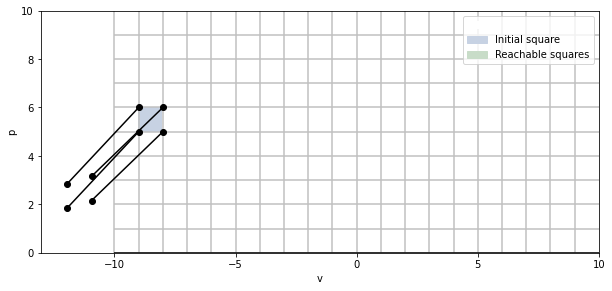

In [6]:
# Show the transition function
grid6 = Grid(1, -9.81, -10, 0, 10, 10)

t = 0.3

example_v, example_p = random.uniform(grid6.v_min, grid6.v_max), random.uniform(grid6.p_min, grid6.p_max)
example_u, example_q = simulate_exact(example_v, example_p, 0, 0, t, grid6.g, False)

print(f"example_v, example_p = {example_v, example_p}")
print(f"example_u, example_q = {example_u, example_q}\n")

square = grid6.box(example_v, example_p)

grid6[square] = 1
for s in grid6.transition(square, t):
    grid6[s] = 2

grid6.draw(grid_color="#c0c0c0", square_types=[("white", ""), ("#c7d2e3", "Initial square"), ("#c8dcc8", "Reachable squares")])


Ivl, Ivu, Ipl, Ipu = grid6.bounds(square)
for v, p in [(v, p) for v in [Ivl, Ivu] for p in [Ipl, Ipu]]:
    w, q = simulate_exact(v, p, 0.85, 0.90, t, grid6.g, False)
    plt.plot([v, w], [p, q], color="black", marker="o")
plt.show()

example_v, example_p = (1, 1)
example_u, example_q = (3.943, 1.74145)

[(3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)]


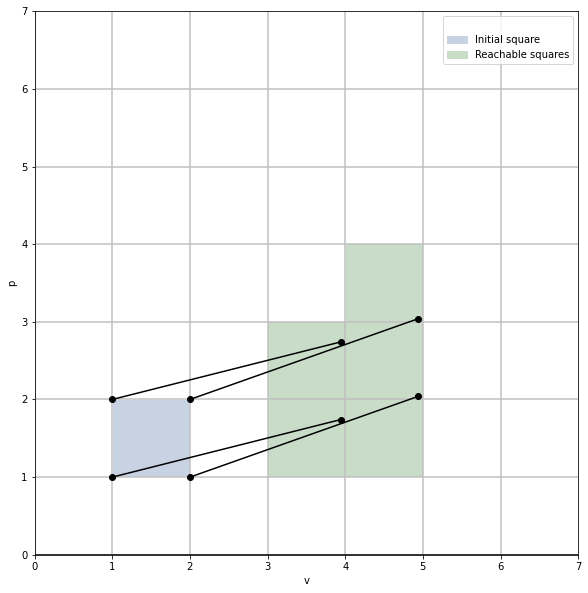

In [8]:
# Draw a figure for the report, showing the transition function in freefall
grid5 = Grid(1, 9.81, 0, 0, 7, 7)

t = 0.3

example_v, example_p = (1,1) #random.uniform(grid5.v_min, grid5.v_max), random.uniform(grid5.p_min, grid5.p_max)
example_u, example_q = simulate_exact(example_v, example_p, 0, 0, t, grid5.g, False)

print(f"example_v, example_p = {example_v, example_p}")
print(f"example_u, example_q = {example_u, example_q}\n")

square = grid5.box(example_v, example_p)

grid5[square] = 1
for s in grid5.transition(square, t):
    grid5[s] = 2

grid5.draw(grid_color="#c0c0c0", square_types=[("white", ""), ("#c7d2e3", "Initial square"), ("#c8dcc8", "Reachable squares")])


Ivl, Ivu, Ipl, Ipu = grid5.bounds(square)
for v, p in [(v, p) for v in [Ivl, Ivu] for p in [Ipl, Ipu]]:
    w, q = simulate_exact(v, p, 0, 0, t, grid5.g, False)
    plt.plot([v, w], [p, q], color="black", marker="o")
plt.show()

In [11]:
# Thest the box function.
# The bounds of the resulting square should contain the boxed point.
grid2 = Grid(0.5, -9.81, -10, -10, 10, 10)

for v in np.arange(-10, 10, 0.1):
    for p in np.arange(-10, 10, 0.1):
        square = grid2.box(v, p)
        Ivl, Ivu, Ipl, Ipu = grid2.bounds(square)
        assert(Ivl <= v)
        assert(v < Ivu)
        assert(Ipl <= p)
        assert(p < Ipu)

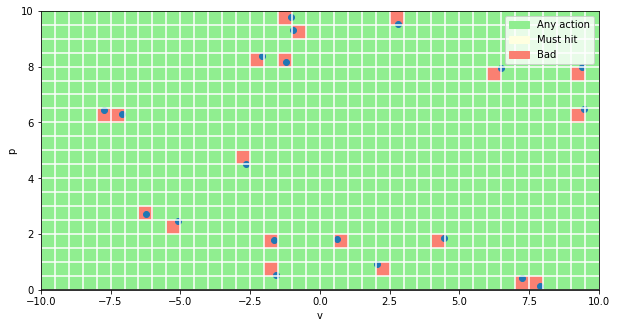

In [12]:
# Test that the grid draws correctly. All blue points should be drawn within their box. 
grid3 = Grid(0.5, -9.81, -10, 0, 10, 10)

points = [(random.uniform(grid3.v_min, grid3.v_max), random.uniform(grid3.p_min, grid3.p_max)) for _ in range(20)]


for v, p in points:
    grid3[grid3.box(v, p)] = 2

grid3.draw()
plt.scatter([x for x, _ in points], [y for _, y in points])

example_v, example_p = (2.2399943749463898, 1.2100142358819632)
example_u, example_q = (-0.21250562505361037, 1.4634503296185606)

square with bounds (2, 3, 1, 2)
in time 0.25 goes to
[(-1, 1), (-1, 2), (0, 1), (0, 2)]
[(-1, 0, 1, 2), (-1, 0, 2, 3), (0, 1, 1, 2), (0, 1, 2, 3)]
(-1, 0, 1, 2)
(-1, 0, 2, 3)
(0, 1, 1, 2)
(0, 1, 2, 3)


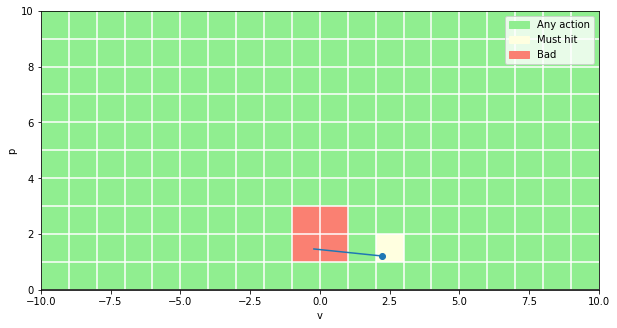

In [ ]:
for _ in range(0, 100):
    _ = input()
    clear_output()
    grid = Grid(1, -9.81, -10, 0, 10, 10)

    #example_v, example_p = (-8.782178771683409, 2.2394383875364077)
    example_v, example_p = random.uniform(grid.v_min, grid.v_max), random.uniform(grid.p_min, grid.p_max)
    example_u, example_q = simulate_exact(example_v, example_p, 0, 0, t, grid.g, False)

    print(f"example_v, example_p = {example_v, example_p}")
    print(f"example_u, example_q = {example_u, example_q}\n")

    square = grid.box(example_v, example_p)
    t = 0.25

    print(f"square with bounds {grid.bounds(square)}")
    print(f"in time {t} goes to")

    new_squares = grid.transition(square, t)

    print([grid.bounds(s) for s in new_squares])

    Ivl, Ivu, Ipl, Ipu = grid.bounds(square)

    grid[square] = 1

    for s in new_squares:
        grid[s] = 2
        print(grid.bounds(s))

    grid.draw()

    plt.plot([example_v, example_u], [example_p, example_q])
    plt.scatter([example_v], [example_p], marker="o")
    plt.show()